In [2]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
from pitchfuncs import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time

2024-04-09 13:57:48.604800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 13:57:48.604828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 13:57:48.605633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 13:57:48.609741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 13:57:49.090744: W tensorflow/compiler/tf2

In [3]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [4]:
model = df
# model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
# model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
# model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
# model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
# model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
6247303,1.12,0.02649,0.24,2.5,12.344279,1.762438,2.135871,5259.764523,0.02649,321.634805,...,-0.97933,-0.984545,-0.989454,-0.992322,-0.993147,-0.992844,-0.99195,-0.990918,-0.989889,-0.988997


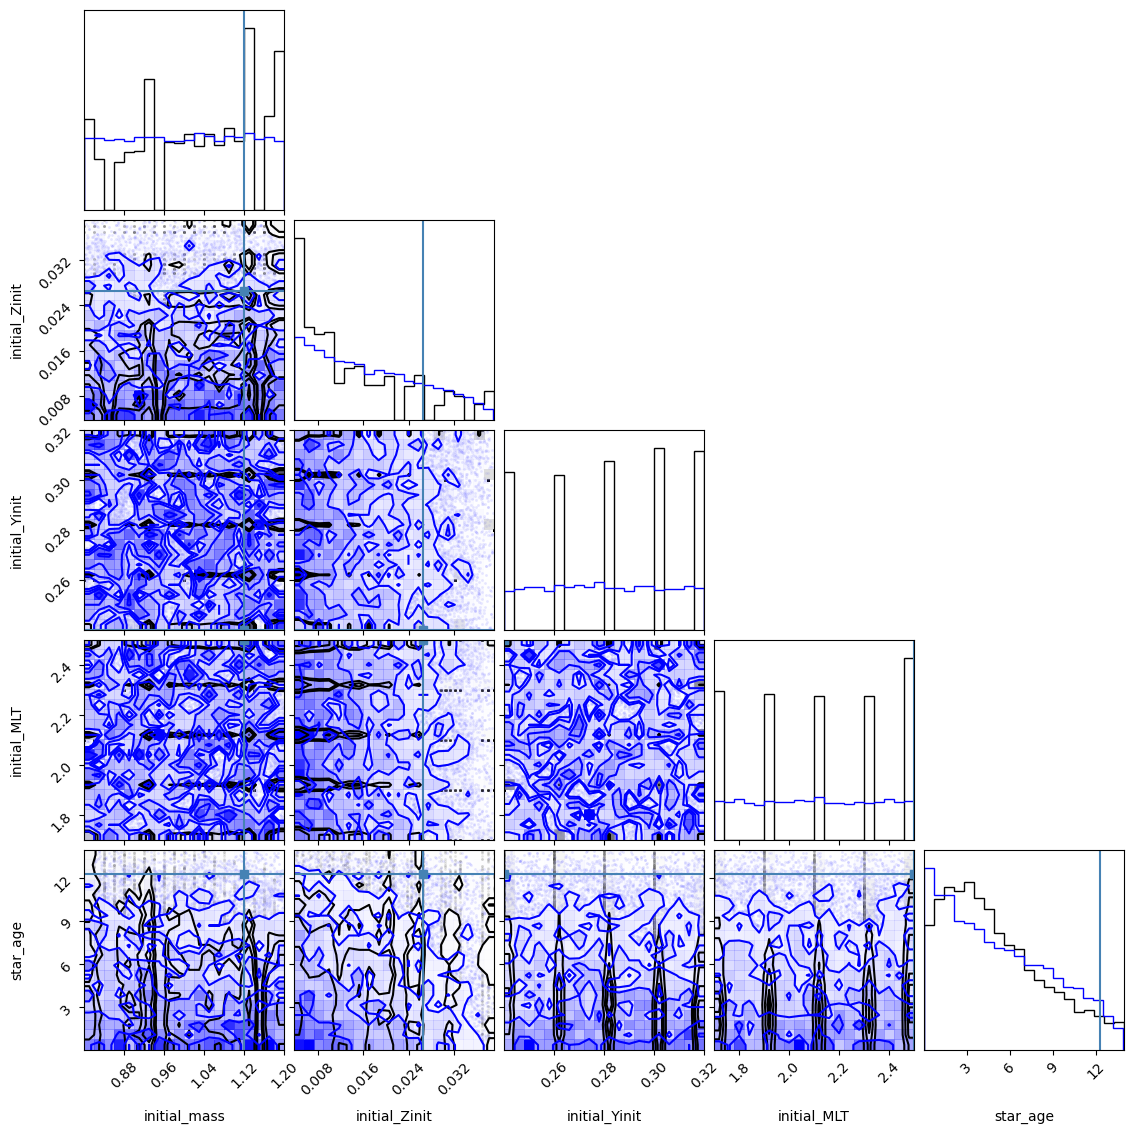

In [5]:
"""
Define priors
"""

def grid_uniform_prior(df, header):
    df_min = df[header].min()
    return scipy.stats.uniform(loc=df_min, scale=df[header].max()-df_min)

def uniform_prior(model_inps, header, scale=0.1):
    model_min = model_inps[header]*(1-scale)
    return scipy.stats.uniform(loc=model_min, scale=(model_inps[header]*(1+scale))-model_min)

def normal_prior(model_inps, header, scale=0.1):
    loc=model_inps[header].values[0]
    return scipy.stats.norm(loc=loc, scale=scale*loc)

def beta_prior(df, header,a=1,b=1):
    df_min = df[header].min()
    return scipy.stats.beta(loc=df_min, scale=df[header].max()-df_min, a=a, b=b)

mass_prior = grid_uniform_prior(df, "initial_mass")

Zinit_prior = beta_prior(df,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(df, "initial_Yinit")

MLT_prior = grid_uniform_prior(df, "initial_MLT")

age_prior = beta_prior(df, "star_age", a=0.9, b=1.5)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000), hist_kwargs={'density':True});

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure,hist_kwargs={'density':True});

In [6]:
pitchfork = emulator("nu6-40_elu_nonorm")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-04-09 13:57:55.085862: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-09 13:57:55.085883: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-04-09 13:57:55.085888: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-04-09 13:57:55.085983: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-04-09 13:57:55.086000: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-04-09 13:57:55.086004: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


In [7]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values[0]
unc = np.array([0.007, 0.015, 0.0001] + [4 + 0.01*(np.abs(i-22))**2 for i in range(5,40)])

iter: 22418 | +1000 | bound: 133 | nc: 1 | ncall: 507191 | eff(%):  4.626 | loglstar:   -inf < -72.520 <    inf | logz: -94.975 +/-    nan | dlogz:  0.001 >  1.009                                   

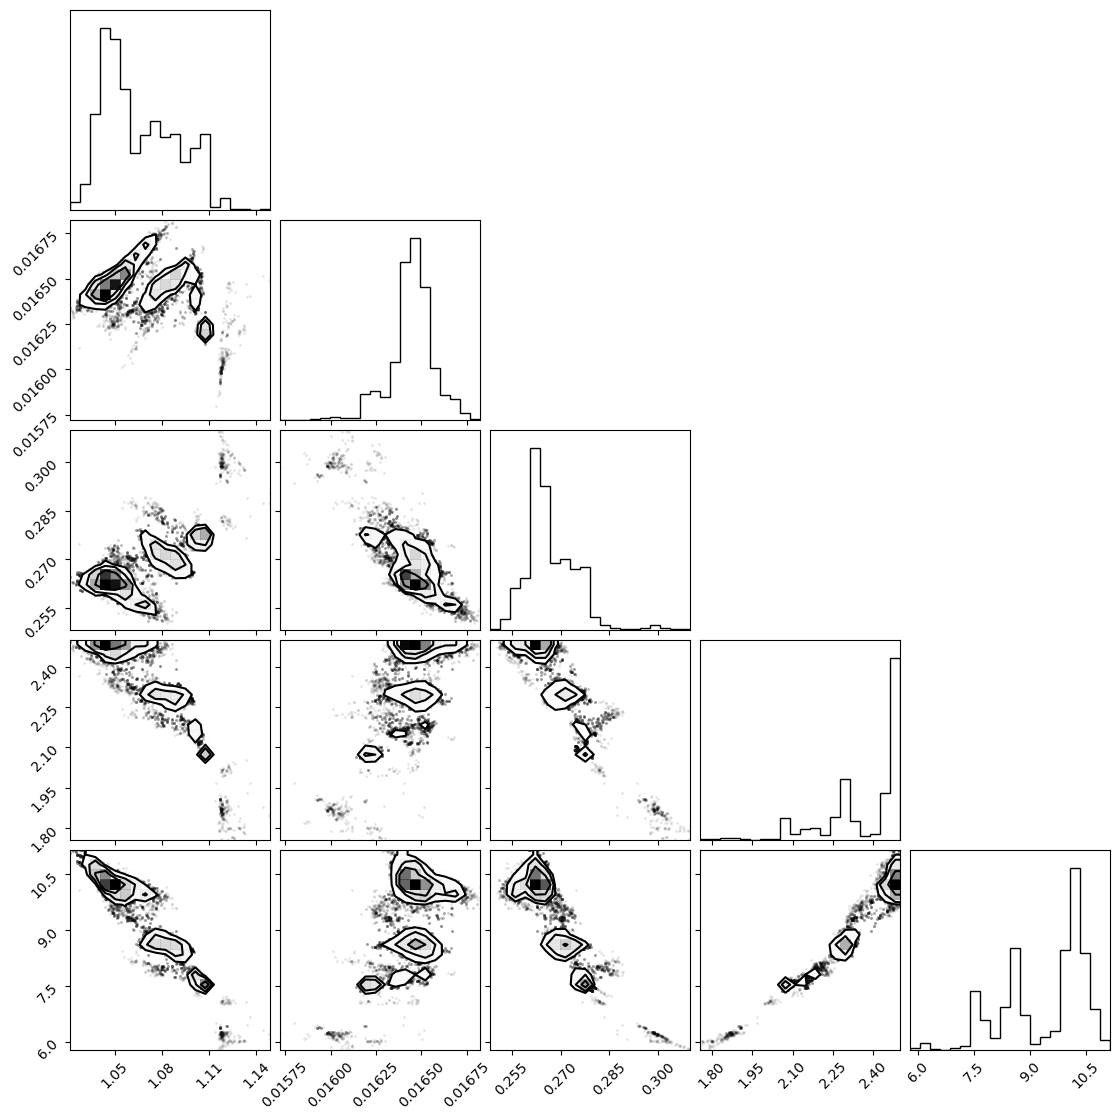

In [9]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler(nlive=1000)
toc = time.time()

corner.corner(posterior);

1877.722181558609


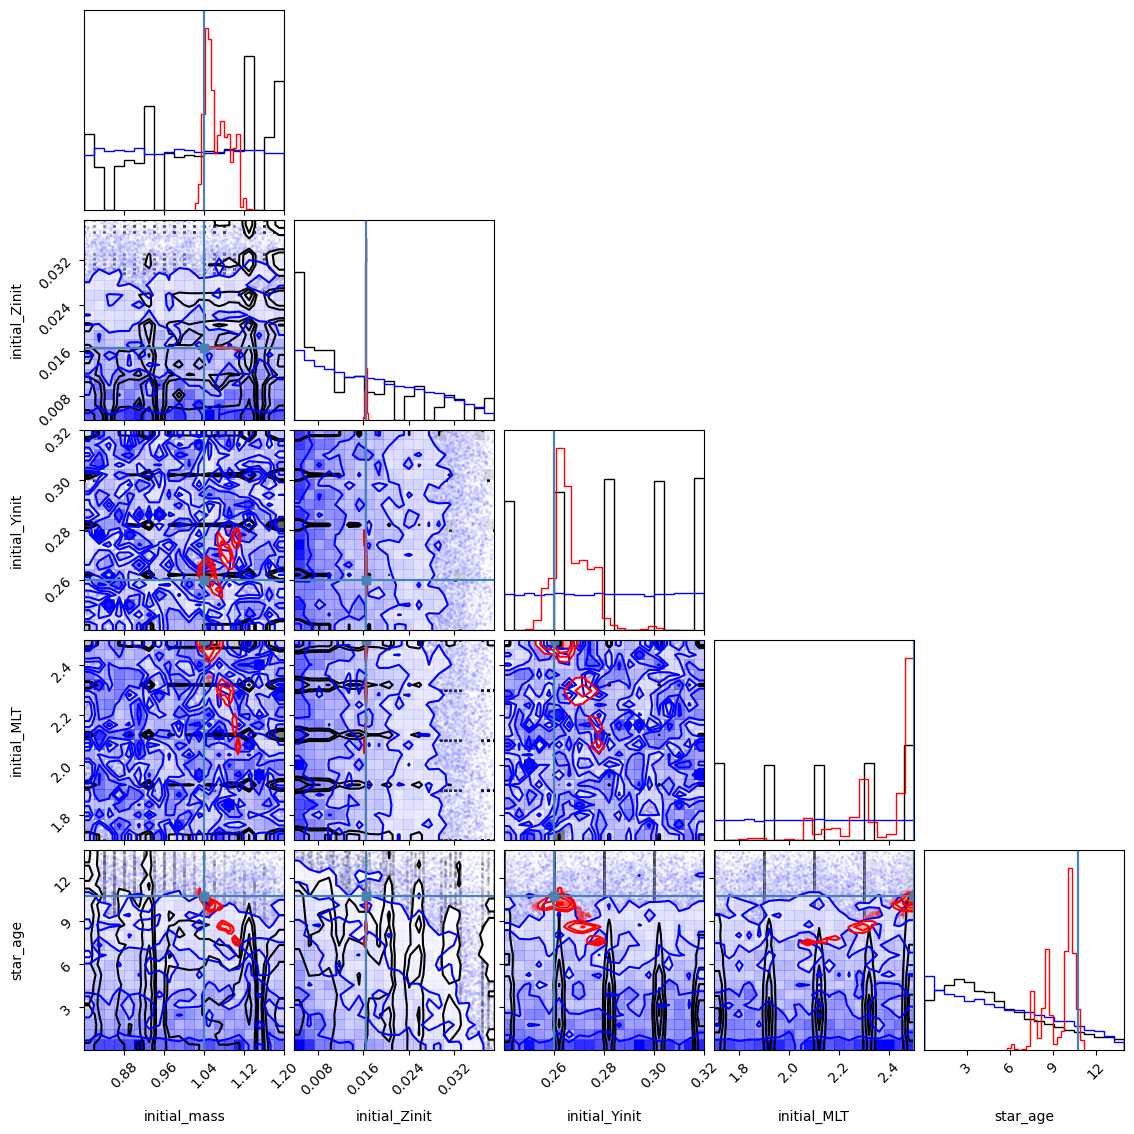

In [10]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

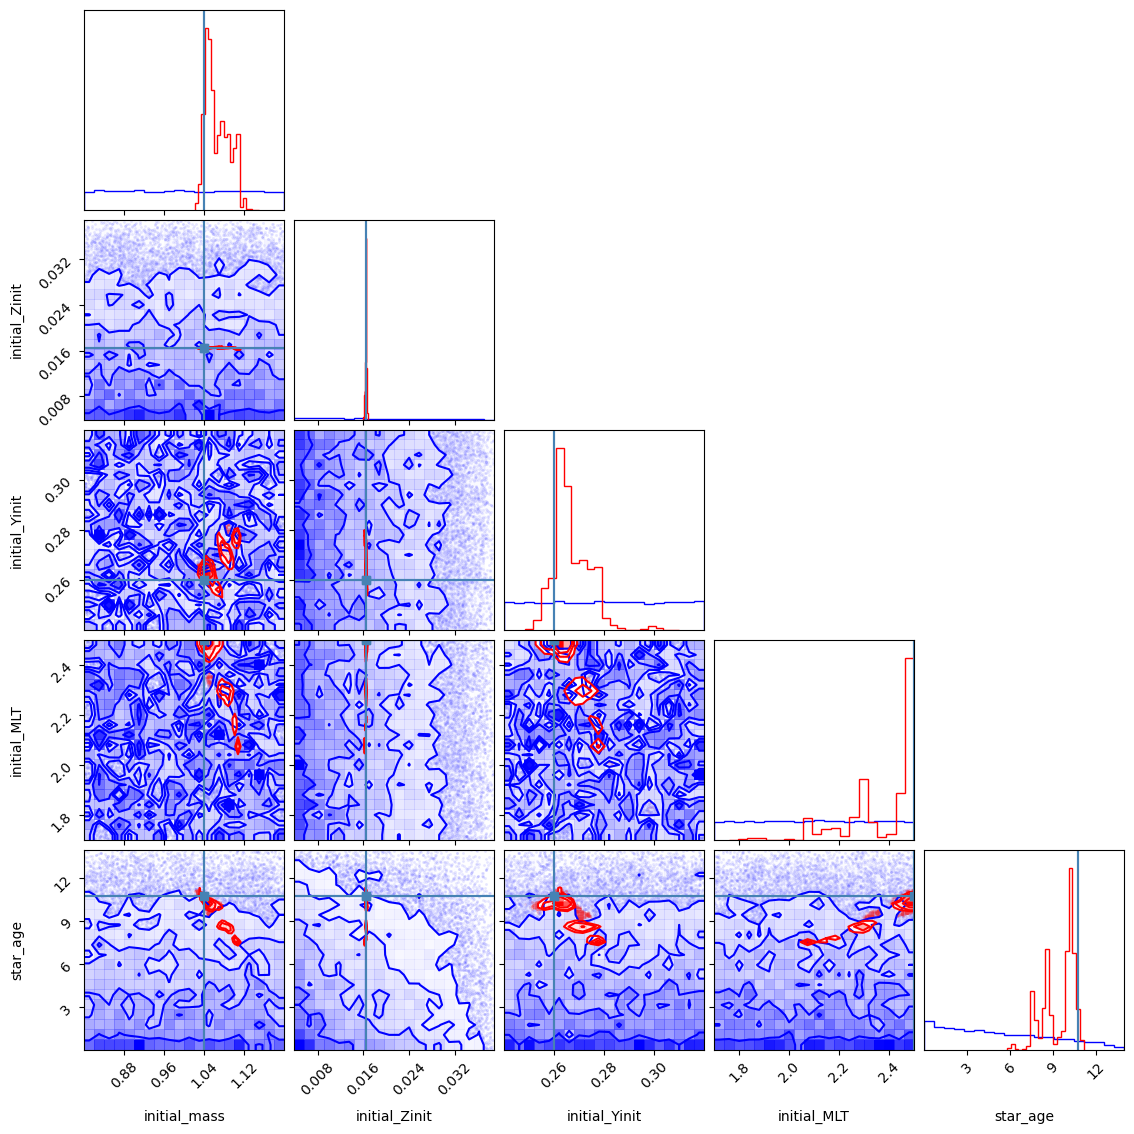

In [11]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

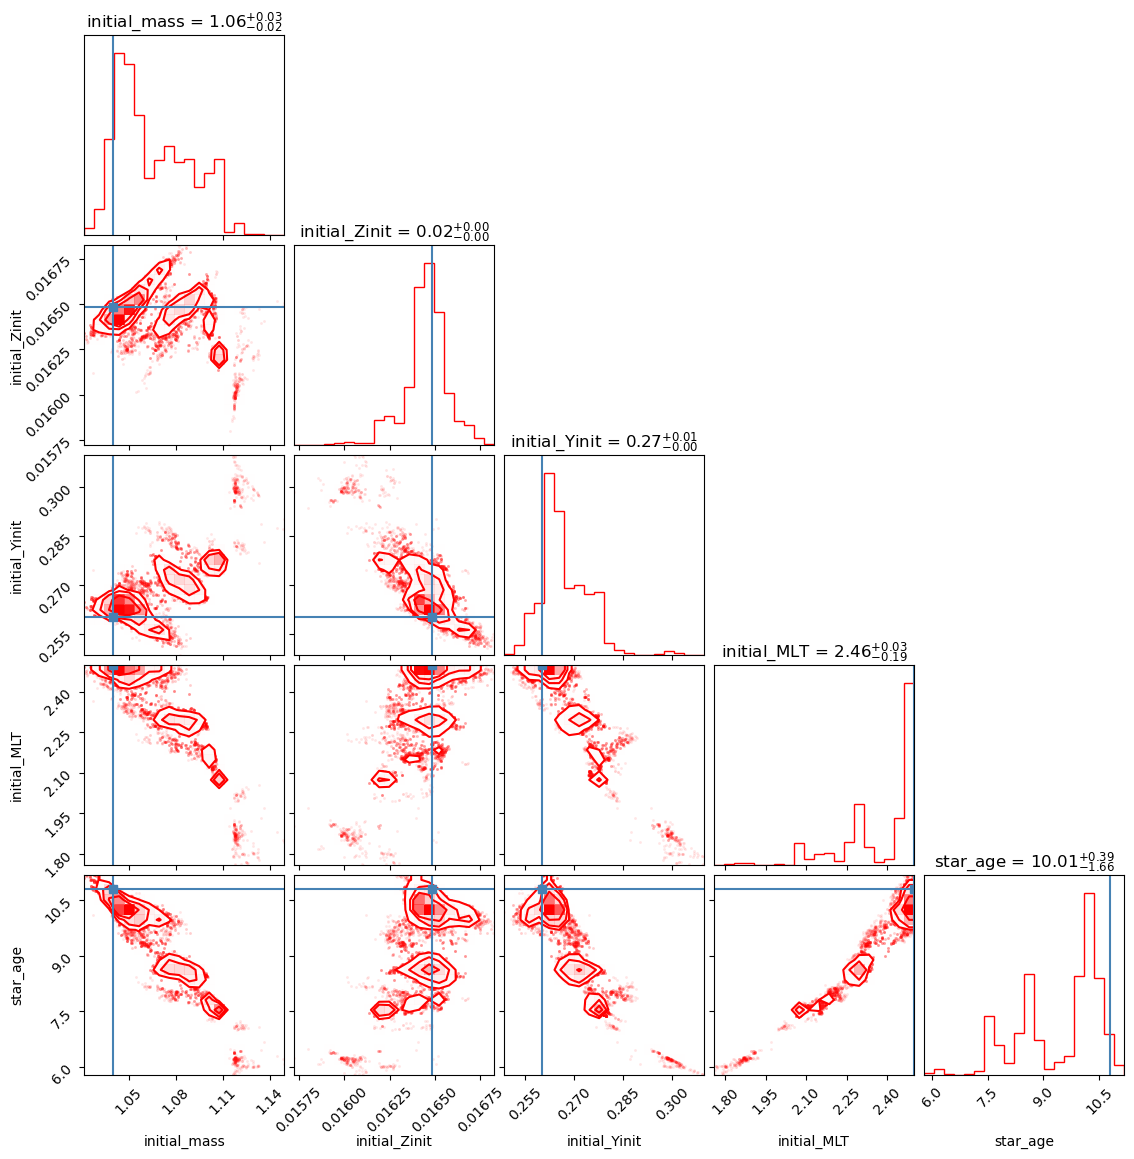

In [12]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True);

In [19]:
%timeit pitchfork.predict([[0,0,0,0,0]])

12.9 ms ± 47.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
import pickle
file_path = "pickle jar/nu6-40_elu"

with open(file_path+".pkl", 'rb') as fp:
    emulator_dict = pickle.load(fp)
    
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

In [18]:
%timeit model.predict([[0,0,0,0,0]])

1/1 [==============================] - 0s 21ms/step
44.4 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
